<a href="https://colab.research.google.com/github/Jameschen7/Digit_Recognition/blob/master/Digit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digit recognition competition

## Data Preperation

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

In [0]:
# data_dir = "data"?
# train_fp = os.path.join(os.path.curdir, data_dir, "train.csv")
# test_fp = os.path.join(data_dir, "test.csv")
train_fp = "/content/drive/My Drive/Colab Notebooks/Digit Recognition/data/train.csv"
test_fp = "/content/drive/My Drive/Colab Notebooks/Digit Recognition/data/test.csv" 

In [13]:
train_fp

'/content/drive/My Drive/Colab Notebooks/Digit Recognition/data/train.csv'

In [0]:
train_df = pd.read_csv(train_fp)
train_df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


label
0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: pixel0, dtype: int64

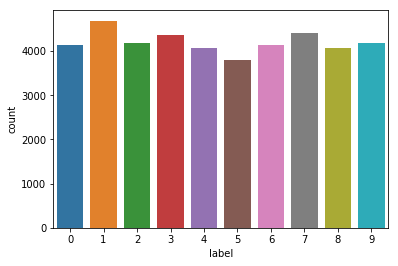

In [0]:
sns.countplot(train_df["label"])
train_df.groupby("label")["pixel0"].count()

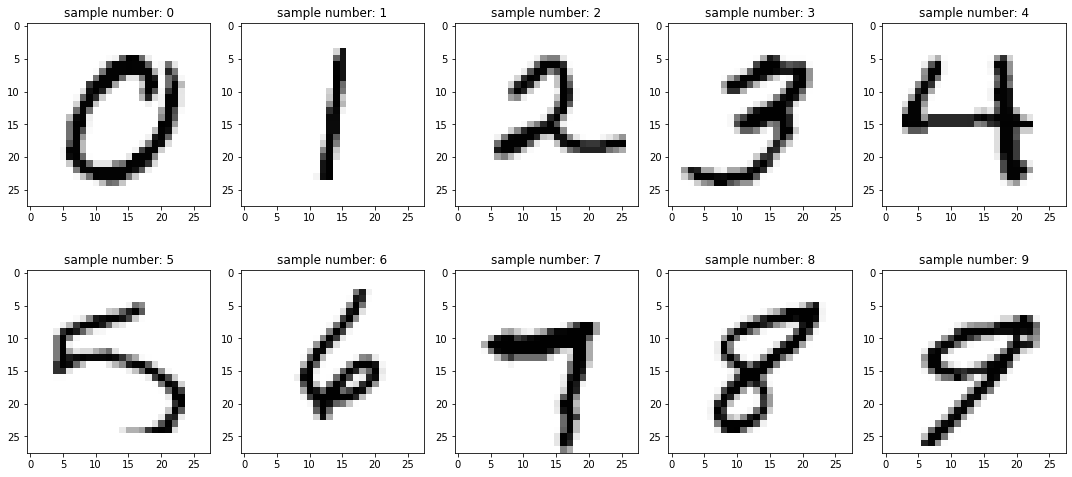

In [0]:
# example picture
sample_pixels = train_df.groupby("label").apply(lambda df: df.sample())
sample_pixels = sample_pixels.set_index("label")

fig, ax = plt.subplots(2,5, figsize=(15,7))
for i in range(10):
    pixel, label = sample_pixels.iloc[i].to_list(), sample_pixels.index[i]
    ax[i//5, i%5].imshow(np.reshape(pixel, (28, 28)), cmap="Greys")
    ax[i//5, i%5].set_title("sample number: %d" % i)
fig.tight_layout()
plt.show()

In [0]:
# data validity check: null and types
print("# of nulls: ", train_df.isnull().sum().sum())
print("types: ", train_df.dtypes.unique())

# of nulls:  0
types:  [dtype('int64')]


In [14]:
# extract and normalize features and labels
train_df = pd.read_csv(train_fp)

X_train = np.reshape(train_df.iloc[:, 1:].values / 255, (-1, 28, 28, 1))
Y_train_class = train_df["label"].values
Y_train = to_categorical(Y_train_class, num_classes=10, dtype=int)   # one-hot encoding

print(X_train.shape, Y_train.shape)

(42000, 28, 28, 1) (42000, 10)


In [15]:
# split training data into training and validation data
random_seed = 2 # Set the random seed for all remaining random_state
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=random_seed)

print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(37800, 28, 28, 1) (4200, 28, 28, 1) (37800, 10) (4200, 10)


0    3721
1    4199
2    3774
3    3933
4    3611
5    3423
6    3724
7    3955
8    3681
9    3779
dtype: int64

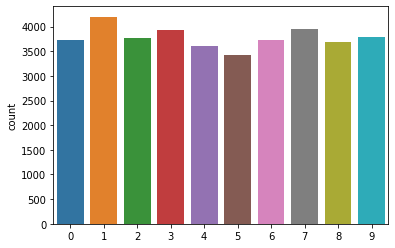

In [0]:
# training data distribution 
sns.countplot(np.argmax(Y_train, axis=1))
pd.Series(np.sum(Y_train, axis=0))

## Data Augmentation

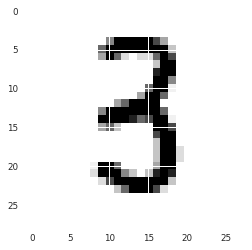

In [155]:
example_index = 1998
plt.imshow(X_train[example_index][:,:,0], cmap="Greys")


In [0]:
# configure an image generator
datagen = ImageDataGenerator(
    width_shift_range=5,
    height_shift_range=4,
    rotation_range=13,
    # shear_range=1,
    zoom_range=0.1
)

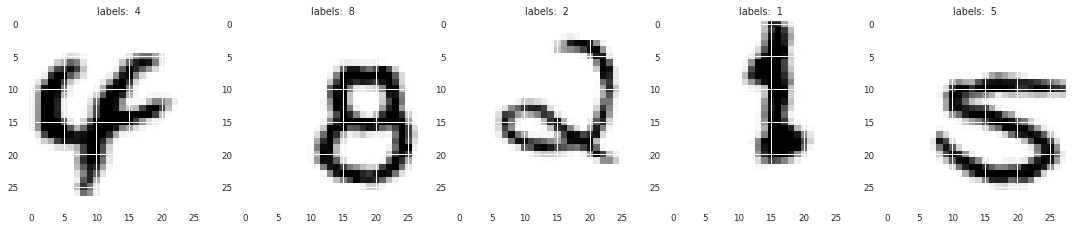

In [160]:
# Demonstrate the example images from data augmentation
example_number = 5
fig, ax = plt.subplots(1,example_number, figsize=[15,9])
it = datagen.flow(X_train, np.argmax(Y_train, axis=1), batch_size=1)
for i in range(example_number):
    example, example_label = it.next()
    # print(example.shape, example_label.shape)
    ax[i].imshow(example[0][:,:,0], cmap="Greys")
    ax[i].set_title("labels: % d" % example_label)
fig.tight_layout()

original shape:  (37800, 28, 28, 1)
1st augmented shape:  (75401, 28, 28, 1)
2nd augmented shape:  (85401, 28, 28, 1) label length:  (85401, 10)


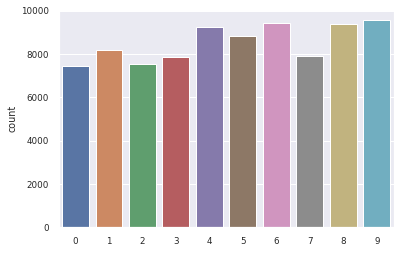

In [244]:
# X_train, X_val
def generate_image(which, train, label, batch_size=500):
    train = train[np.argmax(label, axis=1) == which]
    label = label[np.argmax(label, axis=1) == which]
    it = datagen.flow(train, label, batch_size=batch_size)
    return it.next()
print("original shape: ", X_train.shape)

X_train_aug = np.copy(X_train)
Y_train_aug = np.copy(Y_train)
for i in range(10):
    new_train, new_label = generate_image(i, X_train, Y_train, 4000)
    X_train_aug = np.concatenate((X_train_aug, new_train), axis=0)
    Y_train_aug = np.concatenate((Y_train_aug, new_label), axis=0)
print("1st augmented shape: ", X_train_aug.shape)

important = [4, 5, 6, 8, 9] # the class with poorest accuracy based on the Analysis Result during the initial training without image data augmentation
for i in important:
    new_train, new_label = generate_image(i, X_train, Y_train, 2000)
    X_train_aug = np.concatenate((X_train_aug, new_train), axis=0)
    Y_train_aug = np.concatenate((Y_train_aug, new_label), axis=0)
print("2nd augmented shape: ", X_train_aug.shape, "label length: ", Y_train_aug.shape)

sns.countplot(np.argmax(Y_train_aug, axis=1))

In [248]:
# shuffle
X_train_aug, Y_train_aug = shuffle(X_train_aug, Y_train_aug, random_state=random_seed)
Y_train_aug

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

label:  0


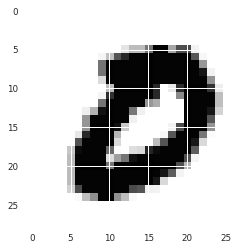

In [246]:
test_index = np.random.randint(-20000, 0)
plt.imshow(X_train_aug[test_index][:,:,0], cmap="Greys")
print("label: ", np.argmax(Y_train_aug[test_index]))

In [24]:
np.concatenate(([[1,2], [1,2], [1,2]], [[1,2]]), axis=0)

array([[1, 2],
       [1, 2],
       [1, 2],
       [1, 2]])

In [0]:
x = [[1,2,3], [1,2,4], [1,2,5]] + [[1,2,6]] 
print(x)
np.random.shuffle(x)
x

[[1, 2, 3], [1, 2, 4], [1, 2, 5], [1, 2, 6]]


[[1, 2, 6], [1, 2, 3], [1, 2, 4], [1, 2, 5]]

In [34]:
Y_train_aug

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

## Model Building & Training
architecture: Input => Conv2d => Conv2d => Flatten => Dense => Dense => Output

In [0]:
# build the layers in the model
model = Sequential()
model.add(Conv2D(32, (5,5), padding="same", activation="relu", use_bias=False, input_shape=(28,28,1)))
model.add(Conv2D(32, (5,5), padding="same", activation="relu", use_bias=False))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3, seed=random_seed))

model.add(Conv2D(64, (5,5), padding="same", activation="relu", use_bias=False))
model.add(Conv2D(64, (5,5), padding="same", activation="relu", use_bias=False))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25, seed=random_seed))

model.add(Conv2D(128, (5,5), padding="same", activation="relu", use_bias=False))
# model.add(Conv2D(128, (5,5), padding="same", activation="relu", use_bias=False))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2, seed=random_seed))

model.add(Flatten())
model.add(Dense(256,  activation="relu", use_bias=False))
model.add(Dropout(0.1, seed=random_seed))
model.add(Dense(256,  activation="relu", use_bias=False))
model.add(Dense(10,  activation="softmax", use_bias=False))

In [0]:
# compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [262]:
# training
epochs = 1
batch_size = 30
# history = model.fit(x=X_train, y=Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val))

history = model.fit(x=X_train_aug, y=Y_train_aug, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val))  # train with the augmented data
# X_train_aug.shape, Y_train_aug.shape

Train on 85401 samples, validate on 4200 samples
Epoch 1/1
85401/85401 [==============================] - 21s 241us/step - loss: 0.0293 - accuracy: 0.9938 - val_loss: 0.0452 - val_accuracy: 0.9945


0.9942857027053833

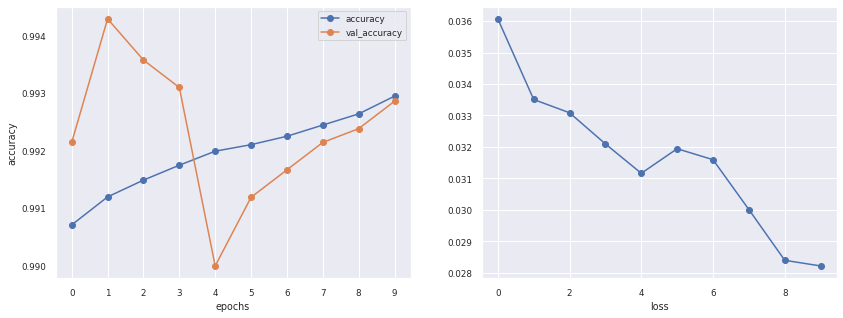

In [193]:
# check convergence and overfitting
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].plot(history.history["accuracy"], marker="o", label="accuracy")
ax[0].plot(history.history["val_accuracy"], marker="o", label="val_accuracy")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("accuracy")
ax[0].legend()
ax[0].set_xticks(ticks=list(range(epochs)))
ax[0].grid(axis="y")

ax[1].plot(history.history["loss"], marker="o", label="loss")
ax[1].set_xlabel("loss")
# ax[1].set_yticks
display(max(history.history["val_accuracy"]))

### Result
1. init: 0.99
2. conv2d bias=true: 0.987
3. dense bias=true: 0.986
4. v2 + drop+ conv2d: 0.989, 0.991
5. v3 + conv2d: 0.9902
6. v4 + maxpool2d + drop: 0.9907, 0.993
7. v4 with rmsprop: 0.99
8. v4 with batch=20: 0.989, 0.9933, 0.994
9. v5 + conv2d + drop: 0.9904, 0.9935, 0.9935
10. v5.1: 0.987, 0.993, 0.996
---
11. v5: 0.9912, 0.991, 0.993
12. v6 + conv2d: 0.988, 0.9917, 0.9928
13. v5 0.2,0.1: 0.991, 0.9928
14. v7 - drop: 0.992, 0.9928, 0.993
15. v8 - dense: 0.993, 0.994, 0.9928, 0.9935
16. v8 +aug: 0.992
17. v5 + aug.2: 0.992, 0.993

## Analysis Result

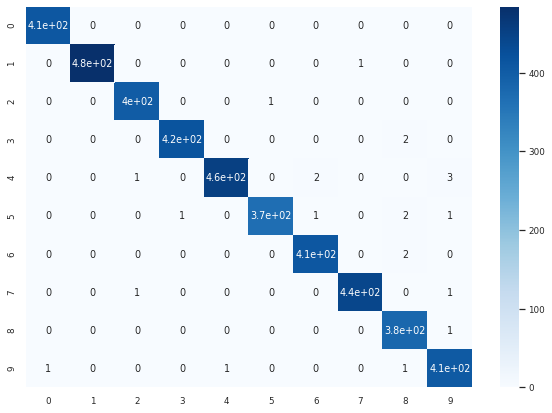

In [263]:
Y_predict = np.argmax(model.predict(X_val), axis=1)
# Y_predict = np.argmax(model.predict(X_train_aug), axis=1)

cm = confusion_matrix(np.argmax(Y_val, axis=1), Y_predict)
# cm = confusion_matrix(np.argmax(Y_train_aug, axis=1), Y_predict)
plt.figure(figsize = (10,7))
sns.set(font_scale=0.8) # for label size
sns.heatmap(pd.DataFrame(cm, index=pd.RangeIndex(10), columns=pd.RangeIndex(10)) , annot=True, cmap=plt.cm.Blues)

In [264]:
(np.argmax(Y_val, axis=1) != Y_predict).sum()

23

In [265]:
Y_val_class = np.argmax(Y_val, axis=1)
# Y_val_class = np.argmax(Y_train_aug, axis=1)
result = pd.DataFrame({"true":Y_val_class, "predict":Y_predict})
result.groupby("true", as_index=False).apply(lambda df: (df["true"] != df["predict"]).sum()).to_frame().rename(columns={0:"count"})

,count
0,0
1,1
2,1
3,2
4,6
5,5
6,2
7,2
8,1
9,3


## Test

In [259]:
test_df = pd.read_csv(test_fp)
X_test = np.reshape(test_df.values / 255, (-1, 28, 28, 1))

test_prediction = np.argmax(model.predict(X_test), axis=1)
test_result_sr = pd.DataFrame({"ImageId": np.arange(1, len(test_prediction)+1), "Label": test_prediction})
test_result_sr

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [0]:
output_fp = os.path.join("/content/drive/My Drive/Colab Notebooks/Digit Recognition/data/submission.csv")
test_result_sr.to_csv(output_fp, index=False)

# Reference:
https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/notebook#2.-Data-preparation
https://github.com/ctwayen/Digit-Recognizer
